# 新闻词云和热点人物分析
### 1.词云
##### 1.1文本预处理

In [22]:
import jieba
import numpy as np
from jieba import posseg
from collections import defaultdict
from itertools import product

def cut(string):
    return list(jieba.cut(string))

def idf(word):
    eps = 1e-6
    return 1/(np.log10(sum(1 for s in sentences if word in s)) + eps)

def tf(word, sentence_cut):
    return sentence_cut.count(word)

def tfidf(word, sentence_cut):
    return tf(word, sentence_cut) * idf(word)

def get_tfidf_from_sentence(sentence_cut):
    tf_idf_words = dict()
    
    for c in set(sentence_cut):
        tf_idf_words[c] = tfidf(c, sentence_cut)
    
    return tf_idf_words

def get_top_tfidf(sentence_cut, ratio=0.25):
    tfidf_value = get_tfidf_from_sentence(sentence_cut)
    top_ratio = ratio
    return sorted(tfidf_value.items(), key=lambda x: x[1], reverse=True)[:int(len(tfidf_value)*top_ratio)]

def is_name(cut_word):
    w, _type = list(posseg.cut(cut_word))[0]
    
    if _type == 'nr': 
        return True
    
    return False

def get_name_correlate(sentence: str):
    name_correlate = defaultdict(lambda : defaultdict(int))
    
    names = []
    
    for w_t in posseg.cut(sentence):
        w, t = tuple(w_t)
        if t == 'nr':
            names.append(w)
        
    for n, w in product(names, repeat=2):
        if n == w: continue
        name_correlate[n][w] += 1
            
    return name_correlate

In [23]:
content = open('../../../git/data_bak/article_9k.txt')
CHARACTERS = content.read()
sentences = CHARACTERS.split('\n')

In [3]:
all_sentences_with_cut_tokens = []
all_sentences_with_cut_tokens = [cut(s) for s in sentences]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/19/dgxwsbgd76728hx577833nx00000gn/T/jieba.cache
Loading model cost 0.629 seconds.
Prefix dict has been built successfully.


##### 1.2用tfidf表征单词

In [4]:
sample_news = get_top_tfidf(all_sentences_with_cut_tokens[99])
sample_news

[('任远明', 1000000.0),
 ('服务卡', 3.321922577293393),
 ('邮储', 2.880754937115057),
 ('工会', 2.1986151062485737),
 ('会籍', 2.0958988814880564),
 ('四川省', 1.877751728962409),
 ('正阳', 1.7954218232340378),
 ('总工会', 1.5276591648884605),
 ('普惠性', 1.4306755346564182),
 ('邮政', 1.3404543612178637),
 ('分行', 1.209673545005994),
 ('会员', 1.1436194292939366),
 ('服务', 1.0351708152199),
 ('省', 0.9591856844299416),
 ('摄据', 0.9266275493897159),
 ('银行', 0.857793461373016),
 ('合作', 0.7672664304498398),
 ('公司', 0.7587249254744466),
 ('党组', 0.7339192276116211),
 ('签约', 0.7227635066571622)]

In [5]:
frequency_dict = {w: tfidf for w, tfidf in sample_news}
frequency_dict

{'任远明': 1000000.0,
 '服务卡': 3.321922577293393,
 '邮储': 2.880754937115057,
 '工会': 2.1986151062485737,
 '会籍': 2.0958988814880564,
 '四川省': 1.877751728962409,
 '正阳': 1.7954218232340378,
 '总工会': 1.5276591648884605,
 '普惠性': 1.4306755346564182,
 '邮政': 1.3404543612178637,
 '分行': 1.209673545005994,
 '会员': 1.1436194292939366,
 '服务': 1.0351708152199,
 '省': 0.9591856844299416,
 '摄据': 0.9266275493897159,
 '银行': 0.857793461373016,
 '合作': 0.7672664304498398,
 '公司': 0.7587249254744466,
 '党组': 0.7339192276116211,
 '签约': 0.7227635066571622}

##### 1.3生成词云

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
wc = WordCloud(font_path='fonts/SimHei.ttf')

In [14]:
def plot_word_cloud(string):
    cut_string = cut(string)
    wc.generate_from_frequencies({k: v for k, v in get_top_tfidf(cut_string)})
    plt.imshow(wc)

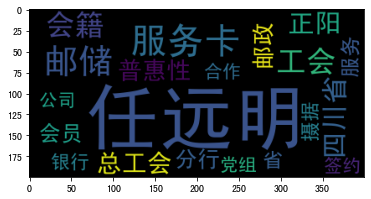

In [15]:
plot_word_cloud(sentences[99])

In [7]:
import matplotlib
print(matplotlib.matplotlib_fname())

/Users/fenghaoguo/opt/anaconda3/envs/p39/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


### 2 热点人物分析
##### 2.1 简单的人物关联图

In [24]:
import networkx as nx

In [25]:
sentences[1000]

'在上周五刚刚结束的挑战的法则中由潘玮柏大张伟戚薇乔杉刘维于小彤组成的首发嘉宾阵容在经过第一期户外挑战和比拼之后迎来了他们首次舞台表演潘玮柏首发登场霸气演绎分裂的时光超完美表演惊艳全场当晚6位嘉宾纷纷放大招拿出自己最擅长的绝技为观众呈现了一场最完美的演出潘玮柏首发登场经典歌曲被遗忘的时光24个比利的全新改编演绎分裂的时光在原曲嘻哈流行的基础上加入弦乐伴奏与合唱团搭配瞬间气势磅礴充满张力尤其独有的潘氏低音炮一开嗓就引发全场尖叫苏到极致让人见识到什么是开口跪系列舞台上的潘玮柏霸气侧漏气场十足特别是高潮处呈现出的那种撕心裂肺的感觉仿佛能把人带到歌的故事里去这个改编跟原曲比起来节奏放缓了却在这缓慢抒情的演绎中又不缺乏爆发力像在对人们诉说着他的音乐他的追求超震撼演绎瞬间引发网友热议这个版本的24个比利太震撼了现场还是那么稳从头赞到尾的表演低音好撩人实力没得说不愧为初代偶像超级帅的现场很有感觉男神魅力依旧不减啊现场是真的稳'

In [26]:
sample_correlate = get_name_correlate(sentences[1000])
sample_correlate

defaultdict(<function __main__.get_name_correlate.<locals>.<lambda>()>,
            {'潘玮柏': defaultdict(int,
                         {'大张伟': 4,
                          '戚薇': 4,
                          '乔杉': 4,
                          '刘维': 4,
                          '张力': 4,
                          '潘氏': 4,
                          '高潮': 4}),
             '大张伟': defaultdict(int,
                         {'潘玮柏': 4,
                          '戚薇': 1,
                          '乔杉': 1,
                          '刘维': 1,
                          '张力': 1,
                          '潘氏': 1,
                          '高潮': 1}),
             '戚薇': defaultdict(int,
                         {'潘玮柏': 4,
                          '大张伟': 1,
                          '乔杉': 1,
                          '刘维': 1,
                          '张力': 1,
                          '潘氏': 1,
                          '高潮': 1}),
             '乔杉': defaultdict(int,
                         {'潘玮柏': 4,
 

In [29]:
simple_graph = defaultdict(list)

for key, relation in sample_correlate.items():
    # print([name for name in relation])
    simple_graph[key] += [name for name in relation]

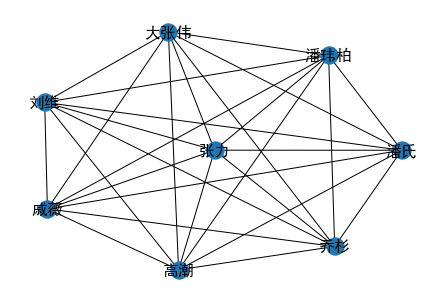

In [31]:
simple_graph_vis = nx.Graph(simple_graph)
nx.draw(simple_graph_vis, with_labels=True, font_size=16)

##### 2.2 带权重的人物关联图

In [33]:
graph_with_weight_vis = nx.Graph()

for k, d in sample_correlate.items():
    for name, value in d.items():
        #print(k, name, value)
        graph_with_weight_vis.add_weighted_edges_from([(k, name, value)])

In [38]:
edges =[]

for k, d in sample_correlate.items():
    for name, value in d.items():
        edges.append((k, name, value))

In [39]:
edges

[('潘玮柏', '大张伟', 4),
 ('潘玮柏', '戚薇', 4),
 ('潘玮柏', '乔杉', 4),
 ('潘玮柏', '刘维', 4),
 ('潘玮柏', '张力', 4),
 ('潘玮柏', '潘氏', 4),
 ('潘玮柏', '高潮', 4),
 ('大张伟', '潘玮柏', 4),
 ('大张伟', '戚薇', 1),
 ('大张伟', '乔杉', 1),
 ('大张伟', '刘维', 1),
 ('大张伟', '张力', 1),
 ('大张伟', '潘氏', 1),
 ('大张伟', '高潮', 1),
 ('戚薇', '潘玮柏', 4),
 ('戚薇', '大张伟', 1),
 ('戚薇', '乔杉', 1),
 ('戚薇', '刘维', 1),
 ('戚薇', '张力', 1),
 ('戚薇', '潘氏', 1),
 ('戚薇', '高潮', 1),
 ('乔杉', '潘玮柏', 4),
 ('乔杉', '大张伟', 1),
 ('乔杉', '戚薇', 1),
 ('乔杉', '刘维', 1),
 ('乔杉', '张力', 1),
 ('乔杉', '潘氏', 1),
 ('乔杉', '高潮', 1),
 ('刘维', '潘玮柏', 4),
 ('刘维', '大张伟', 1),
 ('刘维', '戚薇', 1),
 ('刘维', '乔杉', 1),
 ('刘维', '张力', 1),
 ('刘维', '潘氏', 1),
 ('刘维', '高潮', 1),
 ('张力', '潘玮柏', 4),
 ('张力', '大张伟', 1),
 ('张力', '戚薇', 1),
 ('张力', '乔杉', 1),
 ('张力', '刘维', 1),
 ('张力', '潘氏', 1),
 ('张力', '高潮', 1),
 ('潘氏', '潘玮柏', 4),
 ('潘氏', '大张伟', 1),
 ('潘氏', '戚薇', 1),
 ('潘氏', '乔杉', 1),
 ('潘氏', '刘维', 1),
 ('潘氏', '张力', 1),
 ('潘氏', '高潮', 1),
 ('高潮', '潘玮柏', 4),
 ('高潮', '大张伟', 1),
 ('高潮', '戚薇', 1),
 ('高潮', '乔杉', 1),
 ('高潮', '刘维', 1),


In [40]:
all_weight = set(w for n1, n2, w in edges)
all_weight

{1, 4}

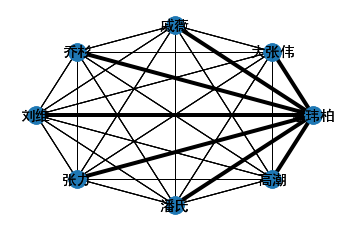

In [50]:
pos = nx.circular_layout(graph_with_weight_vis)

for w in all_weight:
    w_edges = [(node1, node2) for (node1, node2, edge_attr) in graph_with_weight_vis.edges(data=True) if edge_attr['weight']==w]
    width = w
    nx.draw_networkx_edges(graph_with_weight_vis, pos, edgelist=w_edges, width=width)
    nx.draw(graph_with_weight_vis, pos=pos, with_labels=True, font_size=15)

##### 2.3 

In [51]:
key_words = '奥巴马'
hit_ids = []

for i, sentence in enumerate(sentences[:5000]):
    if i % 500 == 0: print(i)
    if key_words in sentence:
        hit_ids.append(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [52]:
total_dictionary = defaultdict(list)

for _id in hit_ids[:10]:
    for key, relation in get_name_correlate(sentences[_id]).items():
        total_dictionary[key] += [name for name in relation]
        
len(total_dictionary)

50

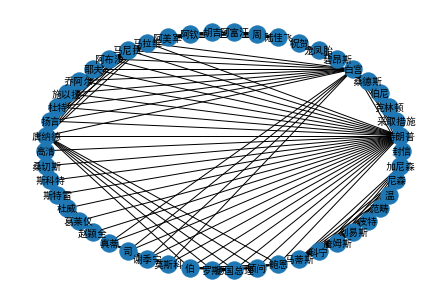

In [56]:
obama_graph = nx.Graph(total_dictionary)
pos = nx.circular_layout(obama_graph)
nx.draw(obama_graph, pos=pos, with_labels=True, font_size=10)